---
title: AR(p) -- Estimation, Uncertainty and Forecasting
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

## Fitting AR(2) to the sunspots dataset

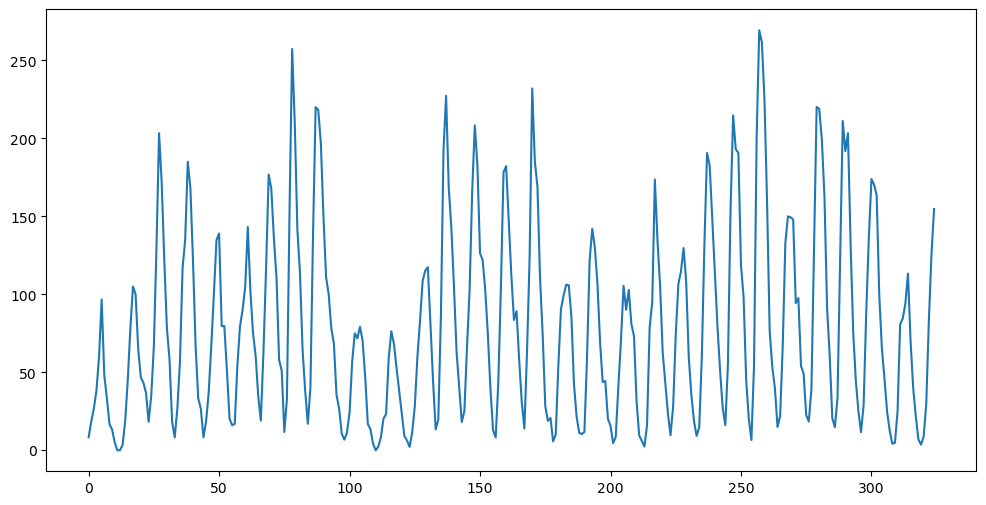

In [2]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
y = sunspots.iloc[:,1].values
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

To fit an AR(p) model, we can use the function AutoReg from statsmodels. This implements the conditional MLE method, and gives frequentist standard errors based on the z-score. 

In [5]:
armod_sm = AutoReg(y, lags = 2, trend = 'c').fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  325
Model:                     AutoReg(2)   Log Likelihood               -1505.524
Method:               Conditional MLE   S.D. of innovations             25.588
Date:                Tue, 01 Apr 2025   AIC                           3019.048
Time:                        23:13:59   BIC                           3034.159
Sample:                             2   HQIC                          3025.080
                                  325                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4561      2.372     10.308      0.000      19.806      29.106
y.L1           1.3880      0.040     34.685      0.000       1.310       1.466
y.L2          -0.6965      0.040    -17.423      0.0

Alternatively, one can simply create $y$ and $X$ and run the usual OLS. This inference method is also valid and can be seen as the result of Bayesian analysis. 

In [6]:
p = 2
n = len(y)
yreg = y[p:] #these are the response values in the autoregression
Xmat = np.ones((n-p, 1)) #this will be the design matrix (X) in the autoregression
for j in range(1, p+1):
    col = y[p-j : n-j].reshape(-1, 1)
    Xmat = np.column_stack([Xmat, col])

armod = sm.OLS(yreg, Xmat).fit()
print(armod.params)
print(armod.summary())
sighat = np.sqrt(np.mean(armod.resid ** 2)) #note that this mean is taken over n-p observations
resdf = n - 2*p - 1
sigols = np.sqrt((np.sum(armod.resid ** 2))/resdf)
print(sighat, sigols)

[24.45610705  1.38803272 -0.69646032]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     774.7
Date:                Tue, 01 Apr 2025   Prob (F-statistic):          2.25e-123
Time:                        23:14:00   Log-Likelihood:                -1505.5
No. Observations:                 323   AIC:                             3017.
Df Residuals:                     320   BIC:                             3028.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

Here are some observations comparing the above two outputs:  
1. The parameter estimates are exactly the same.
2. The regression summary gives t-scores corresponding to each parameter estimate while the AutoReg summary only gives z-scores
3. The standard errors are slightly different.

The standard errors given by the regression summary correspond to the square roots of the diagonal entries of: 
\begin{equation*}
   \hat{\sigma}^2 (X^T X)^{-1} ~~~ \text{ where } \hat{\sigma}^2 = \sqrt{\frac{\|Y - X \hat{\beta}\|^2}{n-2p-1}}
\end{equation*}
while the standard errors reported by AutoReg summary correspond to the square roots of the diagonal entries of:
\begin{equation*}
   \hat{\sigma}_{\text{MLE}}^2 (X^T X)^{-1} ~~~ \text{ where } \hat{\sigma}_{\text{MLE}}^2 = \sqrt{\frac{\|Y - X \hat{\beta}\|^2}{n-p}}
\end{equation*}

In [7]:
covmat = (sighat ** 2) * np.linalg.inv(np.dot(Xmat.T, Xmat))
covmat_ols = (sigols ** 2) * np.linalg.inv(np.dot(Xmat.T, Xmat))
print(np.sqrt(np.diag(covmat)))
print(np.sqrt(np.diag(covmat_ols)))
print(armod_sm.bse)
print(armod.bse)

[2.37245465 0.04001781 0.03997354]
[2.38354959 0.04020495 0.04016048]
[2.37245465 0.04001781 0.03997354]
[2.38354959 0.04020495 0.04016048]


Point predictions for future observations can be obtained by running the recursions discussed in class. One can also obtain predictions from the AutoReg object. The following code verifies that both these prediction methods lead to the same output.

In [8]:
#Predictions
k = 100 
yhat = np.concatenate([y, np.full(k, -9999)]) #extend data by k placeholder values
phi_vals = armod.params
for i in range(1, k+1):
    ans = phi_vals[0]
    for j in range(1, p+1):
        ans += phi_vals[j] * yhat[n+i-j-1]
    yhat[n+i-1] = ans
predvalues = yhat[n:]

#Predictions using Autoreg: 
predvalues_sm = armod_sm.predict(start = n, end = n+k-1)

#Check that both predictions are identical:
print(np.column_stack([predvalues, predvalues_sm]))

[[151.77899784 151.77899784]
 [127.38790987 127.38790987]
 [ 95.56664388  95.56664388]
 [ 68.38511059  68.38511059]
 [ 52.81850228  52.81850228]
 [ 50.14240008  50.14240008]
 [ 57.26940772  57.26940772]
 [ 69.0257265   69.0257265 ]
 [ 80.38020354  80.38020354]
 [ 87.9527796   87.9527796 ]
 [ 90.55582018  90.55582018]
 [ 88.89492689  88.89492689]
 [ 84.7766382   84.7766382 ]
 [ 80.21706503  80.21706503]
 [ 76.75645296  76.75645296]
 [ 75.128572    75.128572  ]
 [ 75.27919896  75.27919896]
 [ 76.6220286   76.6220286 ]
 [ 78.38101438  78.38101438]
 [ 79.88731663  79.88731663]
 [ 80.75304962  80.75304962]
 [ 80.90563559  80.90563559]
 [ 80.51448123  80.51448123]
 [ 79.86527611  79.86527611]
 [ 79.23658165  79.23658165]
 [ 78.81607878  78.81607878]
 [ 78.67026779  78.67026779]
 [ 78.76074092  78.76074092]
 [ 78.98787216  78.98787216]
 [ 79.24012681  79.24012681]
 [ 79.43207661  79.43207661]
 [ 79.52282387  79.52282387]
 [ 79.51509861  79.51509861]
 [ 79.44117383  79.44117383]
 [ 79.34394415

## DATASET TWO

  observation_date  MRTSSM4453USN
0       1992-01-01           1509
1       1992-02-01           1541
2       1992-03-01           1597
3       1992-04-01           1675
4       1992-05-01           1822


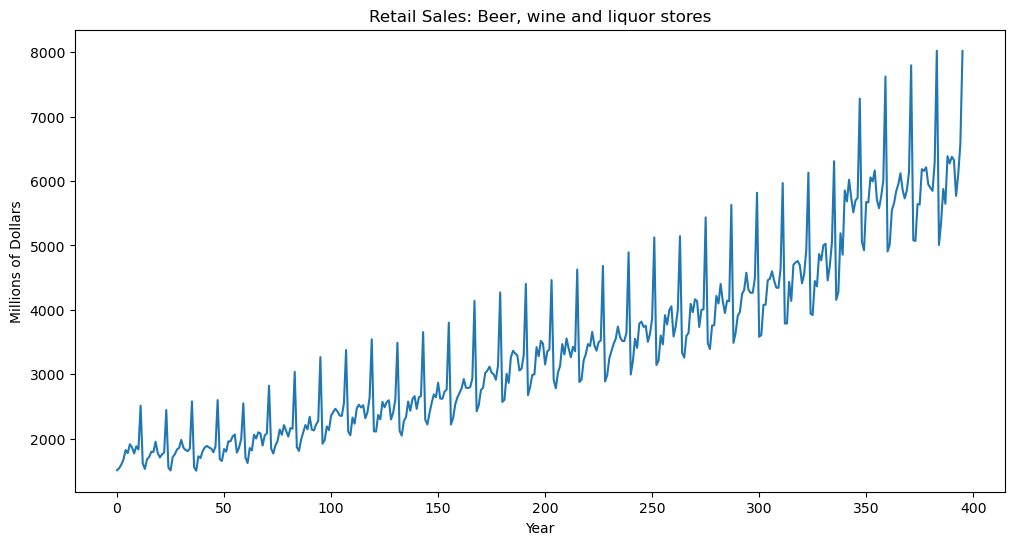

In [9]:
#The following is FRED data on retail sales (in millions of dollars) for beer, wine and liquor stores (https://fred.stlouisfed.org/series/MRTSSM4453USN)
beersales = pd.read_csv('MRTSSM4453USN_March2025.csv')
print(beersales.head())
y = beersales['MRTSSM4453USN'].to_numpy()
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.xlabel('Year')
plt.ylabel('Millions of Dollars')
plt.title('Retail Sales: Beer, wine and liquor stores')
plt.show()

In [11]:
p = 24
armod_sm = AutoReg(y, lags = p, trend = 'c').fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  396
Model:                    AutoReg(24)   Log Likelihood               -2236.965
Method:               Conditional MLE   S.D. of innovations             98.930
Date:                Tue, 01 Apr 2025   AIC                           4525.930
Time:                        23:15:15   BIC                           4627.821
Sample:                            24   HQIC                          4566.394
                                  396                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5601     15.014      0.104      0.917     -27.866      30.987
y.L1           0.2321      0.051      4.576      0.000       0.133       0.332
y.L2           0.3560      0.052      6.828      0.0

In [13]:
p = 24
n = len(y)
yreg = y[p:] #these are the response values in the autoregression
Xmat = np.ones((n-p, 1)) #this will be the design matrix (X) in the autoregression
for j in range(1, p+1):
    col = y[p-j : n-j].reshape(-1, 1)
    Xmat = np.column_stack([Xmat, col])

armod = sm.OLS(yreg, Xmat).fit()
print(np.column_stack([armod_sm.params, armod.params]))
print(armod.summary())
sighat = np.sqrt(np.mean(armod.resid ** 2))
resdf = n - 2*p - 1
sigols = np.sqrt((np.sum(armod.resid ** 2))/resdf)
print(sighat, sigols)

[[ 1.56014754  1.56014754]
 [ 0.23214159  0.23214159]
 [ 0.35595079  0.35595079]
 [ 0.41033105  0.41033105]
 [-0.0641925  -0.0641925 ]
 [-0.05582264 -0.05582264]
 [-0.05762276 -0.05762276]
 [-0.04997887 -0.04997887]
 [ 0.01900069  0.01900069]
 [ 0.24054684  0.24054684]
 [-0.11896504 -0.11896504]
 [ 0.02118707  0.02118707]
 [ 0.78661466  0.78661466]
 [-0.24610645 -0.24610645]
 [-0.35931342 -0.35931342]
 [-0.41785521 -0.41785521]
 [ 0.06855948  0.06855948]
 [ 0.07314519  0.07314519]
 [ 0.06409664  0.06409664]
 [ 0.05262847  0.05262847]
 [-0.01840279 -0.01840279]
 [-0.2588112  -0.2588112 ]
 [ 0.11034825  0.11034825]
 [-0.01284111 -0.01284111]
 [ 0.23732864  0.23732864]]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2859.
Date:   

Once again note the following: 
1. The parameter estimates coming from AutoReg (in sm) and OLS are exactly the same
2. The standard errors are slightly off
3. AutoReg reports z-scores while the OLS output reports t-scores

In [16]:
print(phi_vals)

[ 1.56014754  0.23214159  0.35595079  0.41033105 -0.0641925  -0.05582264
 -0.05762276 -0.04997887  0.01900069  0.24054684 -0.11896504  0.02118707
  0.78661466 -0.24610645 -0.35931342 -0.41785521  0.06855948  0.07314519
  0.06409664  0.05262847 -0.01840279 -0.2588112   0.11034825 -0.01284111
  0.23732864]


In [18]:
#Predictions
k = 100 
yhat = np.concatenate([y.astype(float), np.full(k, -9999)]) #extend data by k placeholder values
phi_vals = armod.params
for i in range(1, k+1):
    ans = phi_vals[0]
    for j in range(1, p+1):
        ans += phi_vals[j] * yhat[n+i-j-1]
    yhat[n+i-1] = ans
predvalues = yhat[n:]

#Predictions using Autoreg: 
predvalues_sm = armod_sm.predict(start = n, end = n+k-1)

#Check that both predictions are identical:
print(np.column_stack([predvalues, predvalues_sm]))

[[ 5212.25793631  5212.25793631]
 [ 5527.15329662  5527.15329662]
 [ 5950.5634424   5950.5634424 ]
 [ 5901.57114654  5901.57114654]
 [ 6646.19799557  6646.19799557]
 [ 6399.13226716  6399.13226716]
 [ 6698.96067878  6698.96067878]
 [ 6515.4937386   6515.4937386 ]
 [ 5950.98324371  5950.98324371]
 [ 6387.98446603  6387.98446603]
 [ 6808.51013886  6808.51013886]
 [ 8329.86644289  8329.86644289]
 [ 5482.59781514  5482.59781514]
 [ 5793.92706153  5793.92706153]
 [ 6238.31280269  6238.31280269]
 [ 6219.46360241  6219.46360241]
 [ 6943.65106033  6943.65106033]
 [ 6719.26850811  6719.26850811]
 [ 7001.21362517  7001.21362517]
 [ 6793.73532563  6793.73532563]
 [ 6220.98207818  6220.98207818]
 [ 6664.31302455  6664.31302455]
 [ 7131.50471473  7131.50471473]
 [ 8654.86597791  8654.86597791]
 [ 5745.26364009  5745.26364009]
 [ 6078.4156102   6078.4156102 ]
 [ 6515.58910276  6515.58910276]
 [ 6491.26480273  6491.26480273]
 [ 7252.9129349   7252.9129349 ]
 [ 6986.07096984  6986.07096984]
 [ 7275.23